In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.cluster import KMeans, DBSCAN
from sklearn.ensemble import IsolationForest
from sklearn.metrics import silhouette_score

In [3]:
# -------------------------------
# Step 1: Load and Prepare Data
# -------------------------------
df = pd.read_excel("/content/Mall Customers.xlsx")  # Replace with your file name

# Focus on selected features
features = df[['Annual Income (k$)', 'Spending Score (1-100)']]

# -------------------------------
# Step 2: Outlier Removal
# -------------------------------
iso = IsolationForest(contamination=0.03, random_state=42)
outliers = iso.fit_predict(features)
df_clean = df[outliers == 1]

# -------------------------------
# Step 3: Scaling
# -------------------------------
scaler = PowerTransformer()  # Alternatively, use StandardScaler()
scaled_features = scaler.fit_transform(df_clean[['Annual Income (k$)', 'Spending Score (1-100)']])


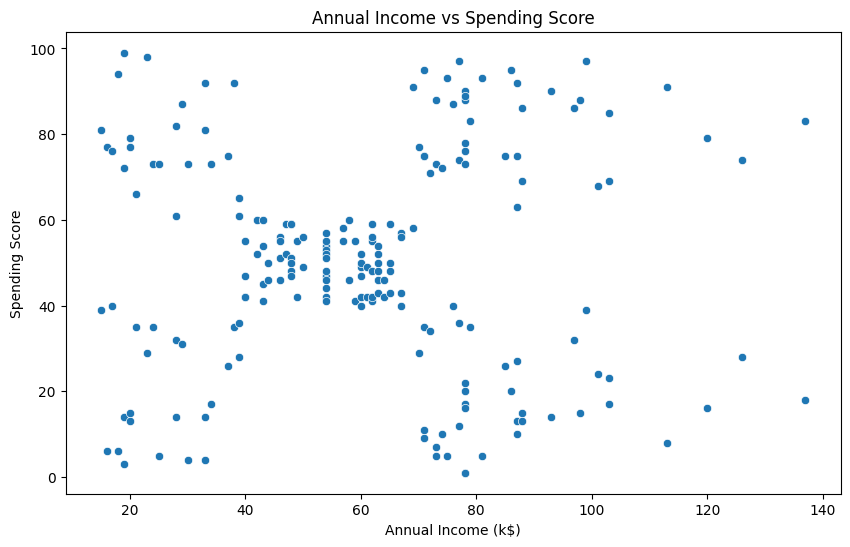

In [5]:
plt.figure(figsize=(10,6))
sns.scatterplot(x='Annual Income (k$)',y='Spending Score (1-100)',data=features)
plt.title("Annual Income vs Spending Score")
plt.xlabel("Annual Income (k$)")
plt.ylabel("Spending Score")
plt.show()

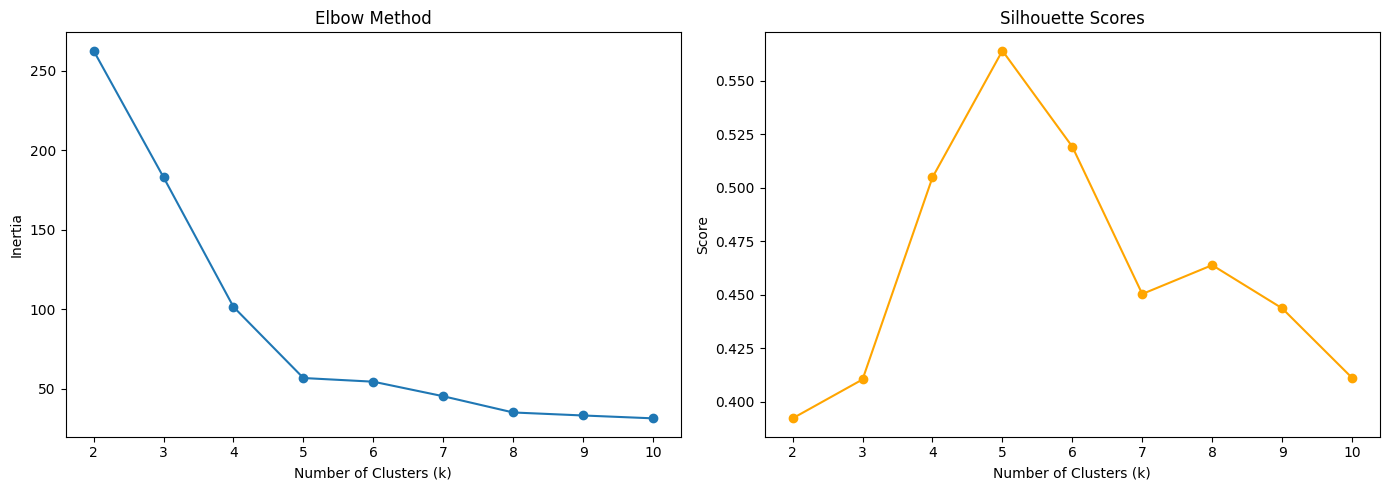

In [6]:
# -------------------------------
# Step 4: Elbow Method for KMeans
# -------------------------------
inertia = []
silhouette_scores = []
K_range = range(2, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(scaled_features)
    inertia.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(scaled_features, labels))

# Plot Elbow and Silhouette
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(K_range, inertia, marker='o')
plt.title("Elbow Method")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia")

plt.subplot(1, 2, 2)
plt.plot(K_range, silhouette_scores, marker='o', color='orange')
plt.title("Silhouette Scores")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Score")
plt.tight_layout()
plt.show()


In [7]:
# -------------------------------
# Step 5: Apply KMeans (k=5 for best score here)
# -------------------------------
kmeans = KMeans(n_clusters=5, random_state=42)
kmeans_labels = kmeans.fit_predict(scaled_features)
df_clean['KMeans_Cluster'] = kmeans_labels

/tmp/ipython-input-7-1824559569.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['KMeans_Cluster'] = kmeans_labels


In [8]:
# -------------------------------
# Step 6: Apply DBSCAN
# -------------------------------
dbscan = DBSCAN(eps=0.5, min_samples=5)
db_labels = dbscan.fit_predict(scaled_features)
df_clean['DBSCAN_Cluster'] = db_labels


/tmp/ipython-input-8-1300655497.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['DBSCAN_Cluster'] = db_labels


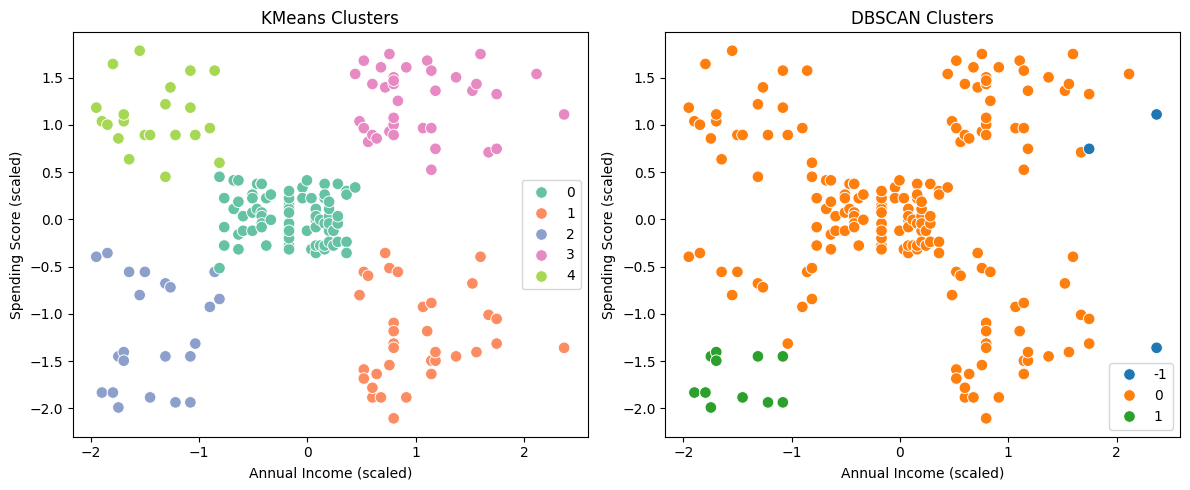

In [9]:
# -------------------------------
# Step 7: Visualize Clusters
# -------------------------------
plt.figure(figsize=(12, 5))

# KMeans Plot
plt.subplot(1, 2, 1)
sns.scatterplot(
    x=scaled_features[:, 0], y=scaled_features[:, 1],
    hue=kmeans_labels, palette='Set2', s=70
)
plt.title("KMeans Clusters")
plt.xlabel("Annual Income (scaled)")
plt.ylabel("Spending Score (scaled)")

# DBSCAN Plot
plt.subplot(1, 2, 2)
sns.scatterplot(
    x=scaled_features[:, 0], y=scaled_features[:, 1],
    hue=db_labels, palette='tab10', s=70
)
plt.title("DBSCAN Clusters")
plt.xlabel("Annual Income (scaled)")
plt.ylabel("Spending Score (scaled)")

plt.tight_layout()
plt.show()

In [16]:
# -------------------------------
# Step 8: Evaluate Cluster Quality
# -------------------------------
print(f"Silhouette Score (KMeans, k=5): {silhouette_score(scaled_features, kmeans_labels):.3f}")
print(f"Silhouette Score (DBSCAN): {silhouette_score(scaled_features, db_labels):.3f}")

# -------------------------------
# Step 9: Analyze Clusters
# -------------------------------
# ----------------------------------
# Analyze Spending per KMeans Cluster
# ----------------------------------
kmeans_profile = df_clean.groupby('KMeans_Cluster')[['Annual Income (k$)', 'Spending Score (100)']].mean()
print("\nAverage Spending per KMeans Cluster:")
print(kmeans_profile.round(2))

Silhouette Score (KMeans, k=5): 0.564
Silhouette Score (DBSCAN): 0.234

Average Spending per KMeans Cluster:
                Annual Income (k$)  Spending Score (1-100)
KMeans_Cluster                                            
0                            54.42                   49.85
1                            83.71                   18.69
2                            25.73                   20.23
3                            84.11                   82.32
4                            26.05                   78.43


In [17]:
# New customer example
new_data = pd.DataFrame({'Annual Income (k$)': [90], 'Spending Score (1-100)': [75]})

# Scale it the same way
scaled_new = scaler.transform(new_data)

# Predict the cluster
pred_cluster = kmeans.predict(scaled_new)
print("Predicted cluster:", pred_cluster)


Predicted cluster: [3]


In [21]:
# ======================
# Cluster Profiling
# ======================

# Basic stats per cluster for KMeans
kmeans_cluster_summary = df_clean.groupby('KMeans_Cluster')[['Annual Income (k$)', 'Spending Score (1-100)']].agg(['mean', 'min', 'max', 'std'])
print("\nKMeans Cluster Summary:\n")
print(kmeans_cluster_summary)

# Customers per cluster for KMeans
kmeans_cluster_counts = df_clean['KMeans_Cluster'].value_counts().sort_index()
print("\nCustomers per KMeans Cluster:\n", kmeans_cluster_counts)

# Basic stats per cluster for DBSCAN
dbscan_cluster_summary = df_clean.groupby('DBSCAN_Cluster')[['Annual Income (k$)', 'Spending Score (1-100)']].agg(['mean', 'min', 'max', 'std'])
print("\nDBSCAN Cluster Summary:\n")
print(dbscan_cluster_summary)

# Customers per cluster for DBSCAN
dbscan_cluster_counts = df_clean['DBSCAN_Cluster'].value_counts().sort_index()
print("\nCustomers per DBSCAN Cluster:\n", dbscan_cluster_counts)


KMeans Cluster Summary:

               Annual Income (k$)                     Spending Score (1-100)  \
                             mean min  max        std                   mean   
KMeans_Cluster                                                                 
0                       54.417722  39   69   8.558408              49.848101   
1                       83.714286  70  120  11.783766              18.685714   
2                       25.727273  15   39   7.566731              20.227273   
3                       84.108108  69  120  12.681535              82.324324   
4                       26.047619  15   39   7.599185              78.428571   

                                   
               min max        std  
KMeans_Cluster                     
0               36  61   6.247232  
1                1  40  11.124354  
2                3  40  12.891237  
3               63  97   9.522062  
4               61  98   9.780447  

Customers per KMeans Cluster:
 KMeans_Cluste